# SHAPELETS LEARNING DEMO (univariate)

Demo for Beggel's ADSL algorithm implementation in pytorch 

In [2]:
import sys
sys.path.append('../')

import torch
from torch import tensor

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.learning.learningextractor import LearningShapelets
from src.SVDD.SVDD import SVDD
from src.util import Scaler

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


## Set up the dataset

### Load the data

Download the data (if needed):

In [3]:
data_name = "Lightning2"
# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)
# np.save(f'../demo/data/{data_name}_train', X_train)
# np.save(f'../demo/data/{data_name}_train_labels', y_train)
# np.save(f'../demo/data/{data_name}_test', X_test)
# np.save(f'../demo/data/{data_name}_test_labeles', y_test)

Or load the data from saved numpy arrays:

In [ ]:
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')

### Preprocessing

#### Get statistics of the entire data:

In [4]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

# if needed use label encoder to transform the labels from strings to integers
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# le.classes_

X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of training data: (60, 637, 1)
Shape of test data: (61, 637, 1)
The different classes: {1, -1}
Shape of the total data: (121, 637, 1)
Number of total samples in each class: [73, 48]


Plot one sample per class:

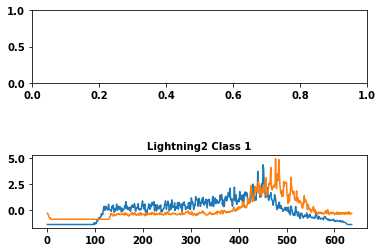

In [6]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# assume the labels start from 1 
for i in [-1, 1]:
    ts = X_train[y_train==i][0,:,]
    ax[i].set_title(f'{data_name} Class {i}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

In [ ]:
# Set seed for determinism
np.random.seed(0)
X_train = X_train[np.logical_or(y_train==3, y_train==4)]
y_train = y_train[np.logical_or(y_train==3, y_train==4)]

X_test = X_test[np.logical_or(y_test==3, y_test==4)]
y_test = y_test[np.logical_or(y_test==3, y_test==4)]
# Set up anomaly detection dataset

normal_class = 1 # choose the normal class
normal_prop = 0.8 # proportion of normal samples that go in train set
alpha = 0.1 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)


Get statistics of the anomaly detection dataset:

In [ ]:
N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))

Trace dataset
number train ts is 44, each of length 275
They belong to two possible classes: {1, -1}
number test ts 56
number of normal train series: 40
number of normal test series: 10


#### Normalize:

In [ ]:
# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

In [ ]:
# normalizer = Normalizer(scaler=StandardScaler())
# X_train_anomaly = normalizer.fit_normalize(X_train_anomaly)
# X_test_anomaly = normalizer.normalize(X_test_anomaly)

#### Plot train and test set

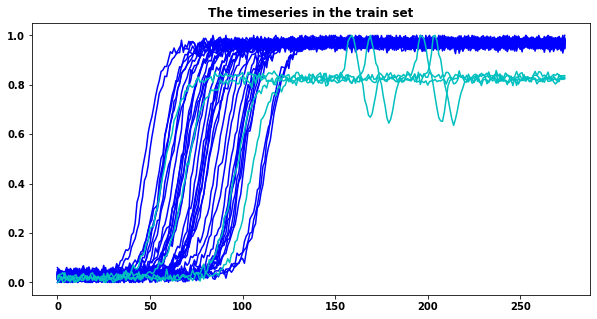

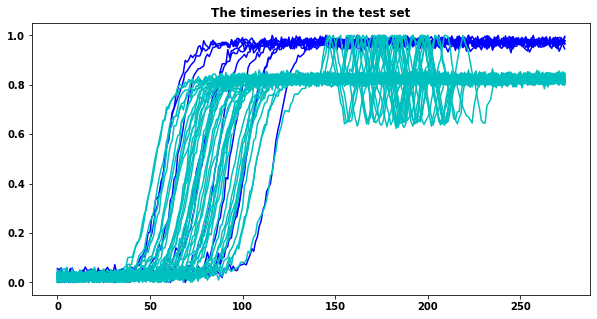

In [ ]:
colors = ['r', 'b', 'g', 'y', 'c']

plt.figure(1, figsize=(10, 5))
for ts, label in zip(X_train_anomaly, y_train_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the train set', fontweight="bold")
plt.show()

plt.figure(2, figsize=(10, 5))
for ts, label in zip(X_test_anomaly, y_test_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the test set', fontweight="bold")
plt.show()


## Train the model:

Implementation of Beggel's "Anomaly Detection algorithm with Shapelet-based Feature Learning" (ADSL).
K Shapelets of length L are parametrized; given the shapelet transform of a multivariate time series $t^i$ with C channels:
\begin{equation}
x^i = (x^i_1, \dots, x^i_K), \enspace x^i_k = min_{l=1,\dots, J} \left\lVert s^k  - t^i_{l, l+L}\right\rVert^2
\end{equation}

Define $l(x^i) = \sum_{k=1}^K (x^i_k)^2$ the norm of the transform vector in $R^K$

Given a batch of N time series, the loss to minimize is:
\begin{equation}
L_S(t^1,\dots,t^N) = \frac{1}{N} \sum_{i=1}^N l(x^i)
\end{equation}

Another option could be using pseudo class labels $y \in \{-1, 1\}$ given by SVDD to update at the end of each epoch:

\begin{equation}
L_S((t^1, y_1),\dots,(t^N, y_N)) = \frac{1}{N_1} \sum_{y_i=1} l(x^i)
\end{equation}
where $N_1 = |\{i, y_i=1\}|$

#### Initialize the shapelets' parameters using KMeans:

Auxiliary functions:

In [ ]:
def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, len_ts, n_channels = X.shape
    # Return a k sized list of elements chosen from the population with replacement
    samples_i = random.choices(range(n_ts), k=n_segments) 
    segments = np.empty((n_segments, shapelets_size, n_channels))
    for i, k in enumerate(samples_i):
        # take a random index s from start to stop both included!
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, s:s+shapelets_size, :]
    return segments

In [ ]:
def get_weights_via_kmeans(X, len_shapelets, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    @return: clusters array shape (num_shapelets, len_shapelets, in_channels)
    """
    segments = sample_ts_segments(X, len_shapelets, n_segments)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_
    return clusters

Set up the hyperparameters (length and number of shapelets) and shapelets' parameters:

In [ ]:
K_star = 0.02
L_star = 0.4
L = round(L_star*Q)
K = round(K_star*Q)
clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
# set_shapelet_weights needs input of shape (num_shapelets, in_channels, len_shapelets)
clusters_centers = clusters_centers.transpose(0,2,1)
print(f'The shape of cluster centers is {clusters_centers.shape}')
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, verbose=1, to_cuda=False)
extractor.set_shapelet_weights(clusters_centers)

The shape of cluster centers is (6, 1, 110)


Set the optimzer:

In [ ]:
lr = 1e-3
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, verbose=1, to_cuda=False)
extractor.set_shapelet_weights(clusters_centers)
optimizer = torch.optim.SGD(extractor.model.parameters() ,lr=lr)
extractor.set_optimizer(optimizer)

#### Train the model and plot the shapelets:

In [ ]:
n_epoch_steps = 60
n_epochs = 20
# total epochs = n_epoch_steps * n_epochs
batch_size = 8

# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)

losses = []
for _ in range(n_epoch_steps):
    losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)

Loss: 2.840606689453125: 100%|██████████| 20/20 [00:00<00:00, 45.04it/s] 


Plot the loss decay:

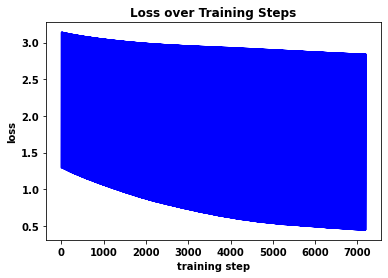

In [ ]:
plt.plot(losses, color='blue')
plt.title("Loss over Training Steps", fontweight="bold")
plt.xlabel("training step")
plt.ylabel("loss")
plt.show()

Get the shapelets and plot them:

Type and shape of the shapelets in output <class 'numpy.ndarray'> (6, 110, 1)


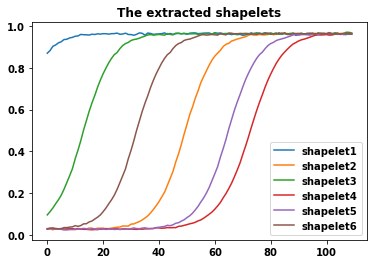

In [ ]:
S = extractor.get_shapelets()
# use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
S = np.moveaxis(S, 1, 2)
print('Type and shape of the shapelets in output', type(S),  S.shape)

plt.figure()
for i in range(len(S)):
    shap = S[i,:,]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

In [ ]:
x = S[3,:,0]
y = S[4,:,0]

mu_x = np.mean(x)
sd_x = np.std(x)
x = (x - mu_x) / (sd_x*len(x))

mu_y = np.mean(y)
sd_y = np.std(y)
y = (y - mu_y) /sd_y


z = np.correlate(x,y, mode='full')
max(z)

0.9703234

Transform train and test set:

In [ ]:
# tranform method takes in input a tensor of shape (n_samples, in_channels, len_ts) 
# and outputs a numpy array of shape (n_samples, n_shapelets)
X_train_transform = extractor.transform(X_train_tensor)

X_test_tensor = tensor(X_test_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X_test_transform = extractor.transform(X_test_tensor)

# check if type and shape are correct:
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (44, 6)
Type and shape of transformed test data <class 'numpy.ndarray'> (56, 6)


## Anomaly detection using SVDD

Choose how many extracted shapelets to take (2 for visualization purposes):

In [ ]:
print('The maximum number of shapelets that can be taken is', K)
n_shap = 2 # n_shap must be <= K
X_train_transform = X_train_transform[:,0:n_shap]
X_test_transform = X_test_transform[:,0:n_shap]
print(X_train_transform.shape)

The maximum number of shapelets that can be taken is 6
(44, 2)


Set up the parameter C in two ways:
1. using proportion of anomalies w.r.t. the total number of time series in the train set
2. using proportion of anomalies w.r.t. the number of normal time series in the train set (little bit higher, as in Beggel's paper)

This changes because the resulting C in 2. is a bit smaller, giving a tighter boundary.

The more C is small the more the boundary is tight.

OBSERVATION: often (as in GunPoint dataset) we prefer a tighter boundary because some normal observations may differ from the trend.

In [ ]:
# nu is the proportion of anomalies w.r.t. the total
nu = np.around(len(y_train_anomaly[y_train_anomaly==-1])/len(y_train_anomaly), 3)
print(nu)

# set C with real percentage of anomalies
C1 = 1 / (N * nu)
print(C1)

# set C according to Beggel's paper (smaller)
C2 = 1 / (N * alpha)
print(C2)

0.091
0.2497502497502498
0.22727272727272727


In [ ]:
svdd = SVDD(C=C2, zero_center=True)

# fit the model
svdd.fit(X_train_transform)

5 support vectors out of 44 points
Solution found with center in 0.0 and radius 0.45067062973976135


EVALUATE the prediction:

In [ ]:
## TRAIN
# BALANCED ACCURACY
y_train_predict = svdd.predict(X_train_transform)
train_ba = balanced_accuracy_score(y_train_anomaly, y_train_predict)
print("SVDD train balanced accuracy:", train_ba)

# AUC
y_train_scores = svdd.decision_function(X_train_transform)
auc_train = roc_auc_score(y_train_anomaly, y_train_scores)
print("SVDD train AUC:", auc_train)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD train balanced accuracy: 1.0
SVDD train AUC: 1.0
SVDD train F1 score: 1.0


In [ ]:
## TEST
# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("SVDD test balanced accuracy:", test_ba)

# AUC
y_test_scores = svdd.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("SVDD test AUC:", auc_test)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD test balanced accuracy: 1.0
SVDD test AUC: 1.0
SVDD train F1 score: 1.0


### PLOTS (first two coordinates in shapelet transformed space):

NOTE: if were taken more than 2 shapelets the SVDD boundaries are plotted but they do not indicate the correct boundary in more than two dimension of the true points (the points are collapsed in the plane as if their other coordinates were equal to zero)

TRAIN DATA and SVDD boundary

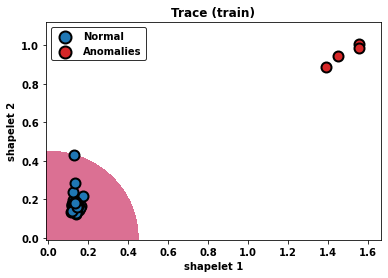

In [ ]:
x_max = max(X_train_transform[:,0])+0.01
y_max = max(X_train_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_train = y_train_anomaly == 1
nIndex_train = y_train_anomaly == -1


plt.figure()
plt.title(f"{data_name} (train)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_train_transform[pIndex_train, 0], X_train_transform[pIndex_train, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_train_transform[nIndex_train, 0], X_train_transform[nIndex_train, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                    markerscale=1.2, fancybox=True)
plt.xlim((-0.01, x_max + 0.1))
plt.ylim((-0.01, y_max + 0.1))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()

TEST DATA and SVDD boundary

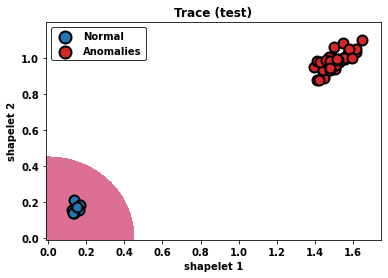

In [ ]:
x_max = max(X_test_transform[:,0])+0.1
y_max = max(X_test_transform[:,1])+0.1
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_test = y_test_anomaly == 1
nIndex_test = y_test_anomaly == -1
auc_test = np.around(auc_test, 3)
plt.figure()
plt.title(f"{data_name} (test)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_test_transform[pIndex_test, 0], X_test_transform[pIndex_test, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_test_transform[nIndex_test, 0], X_test_transform[nIndex_test, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                     markerscale=1.2, fancybox=True)

plt.xlim((-0.01, x_max))
plt.ylim((-0.01, y_max))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()